<a href="https://colab.research.google.com/github/Farmhouse121/Financial-Data-Science-in-Python/blob/main/Alphas/Filter_Rules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Investigation of Filter Rules
---
## Load useful packages...

In [1]:
from my_library import *

09:05:49 Starting...
09:05:49 Installing yfinance into Google notebook...
09:05:51 Installing arch into Google notebook...
09:05:59 Initialized.


## Get S&P 500 Index Data from Yahoo! Finance

In [54]:
nprint("Fetching data from Yahoo!...")
data,sname=download(ticker:='^GSPC','1990-01-02','2019-12-31',auto_adjust=True,progress=False),'S&P 500 Index'
data.columns=data.columns.get_level_values(0)
data.columns.name=ticker
data.index=pd.PeriodIndex(data.index,freq='B')
data['Return']=data['Close'].pct_change()*hundred
data.dropna(inplace=True)
display(data)

14:24:49 Fetching data from Yahoo!...


<ipython-input-54-43667b27eb47>:5: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  data.index=pd.PeriodIndex(data.index,freq='B')


^GSPC,Close,High,Low,Open,Volume,Return
Date,,,,,,
1990-01-03,358.760010,360.589996,357.890015,359.690002,192330000,-0.258554
1990-01-04,355.670013,358.760010,352.890015,358.760010,177000000,-0.861299
1990-01-05,352.200012,355.670013,351.350006,355.670013,158530000,-0.975624
1990-01-08,353.790009,354.239990,350.540009,352.200012,140110000,0.451447
1990-01-09,349.619995,354.170013,349.609985,353.829987,155210000,-1.178669
...,...,...,...,...,...,...
2019-12-23,3224.010010,3227.780029,3222.300049,3226.050049,3064530000,0.086614
2019-12-24,3223.379883,3226.429932,3220.510010,3225.449951,1296530000,-0.019545
2019-12-26,3239.909912,3240.080078,3227.199951,3227.199951,2164540000,0.512817


## Fit baseline AR(1) GJR-GARCH model

In [59]:
from arch.univariate import ARX
model = ARX(data['Return'],lags=1)
model.volatility = GARCH2(0,1,1)
model.distribution = GeneralizedError2()
fit=model.fit(update_freq=0,disp='off')
nprint(fit.summary(),sep='\n')
display(baseline:=pd.DataFrame([fit.params,fit.std_err]).T)
data['Volatility']=fit.conditional_volatility
data['Alpha']=baseline.loc['Const','params']+baseline.loc['Return[1]','params']*data['Return'].shift()
data['Z Score']=(data['Return']-data['Alpha'])/data['Volatility'].shift()
display(data)

14:27:02                                AR - GJR-GARCH Model Results                               
Dep. Variable:                             Return   R-squared:                       0.002
Mean Model:                                    AR   Adj. R-squared:                  0.002
Vol Model:                              GJR-GARCH   Log-Likelihood:               -9579.08
Distribution:      Generalized Error Distribution   AIC:                           19170.2
Method:                        Maximum Likelihood   BIC:                           19211.7
                                                    No. Observations:                 7556
Date:                            Mon, Feb 03 2025   Df Residuals:                     7554
Time:                                    14:27:02   Df Model:                            2
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
--------------

,params,std_err
Const,0.048207,0.007658
Return[1],-0.027622,0.010968
omega,0.014869,0.002806
gamma[1],0.162625,0.018760
beta[1],0.902751,0.010589
nu,1.362613,0.036799


^GSPC,Close,High,Low,Open,Volume,Return,Volatility,Alpha,Z Score
Date,,,,,,,,,
1990-01-03,358.760010,360.589996,357.890015,359.690002,192330000,-0.258554,NaN,NaN,NaN
1990-01-04,355.670013,358.760010,352.890015,358.760010,177000000,-0.861299,1.023971,0.055349,NaN
1990-01-05,352.200012,355.670013,351.350006,355.670013,158530000,-0.975624,1.047885,0.071998,-1.023097
1990-01-08,353.790009,354.239990,350.540009,352.200012,140110000,0.451447,1.088407,0.075156,0.359096
1990-01-09,349.619995,354.170013,349.609985,353.829987,155210000,-1.178669,1.041295,0.035738,-1.115765
...,...,...,...,...,...,...,...,...,...
2019-12-23,3224.010010,3227.780029,3222.300049,3226.050049,3064530000,0.086614,0.488883,0.034549,0.104490
2019-12-24,3223.379883,3226.429932,3220.510010,3225.449951,1296530000,-0.019545,0.480242,0.045815,-0.133692
2019-12-26,3239.909912,3240.080078,3227.199951,3227.199951,2164540000,0.512817,0.473041,0.048747,0.966323


## Fit a Basic "Filter Rules" Model

14:53:33 Creating filter rule indicators with order 3 and offset 0.100000.
14:53:33 Fitting GJR-GARCH model with filter rules...
14:53:34                               AR-X - GJR-GARCH Model Results                              
Dep. Variable:                             Return   R-squared:                       0.002
Mean Model:                                  AR-X   Adj. R-squared:                  0.001
Vol Model:                              GJR-GARCH   Log-Likelihood:               -9479.25
Distribution:      Generalized Error Distribution   AIC:                           18984.5
Method:                        Maximum Likelihood   BIC:                           19074.5
                                                    No. Observations:                 7486
Date:                            Mon, Feb 03 2025   Df Residuals:                     7477
Time:                                    14:53:33   Df Model:                            9
                                  Mean Mode

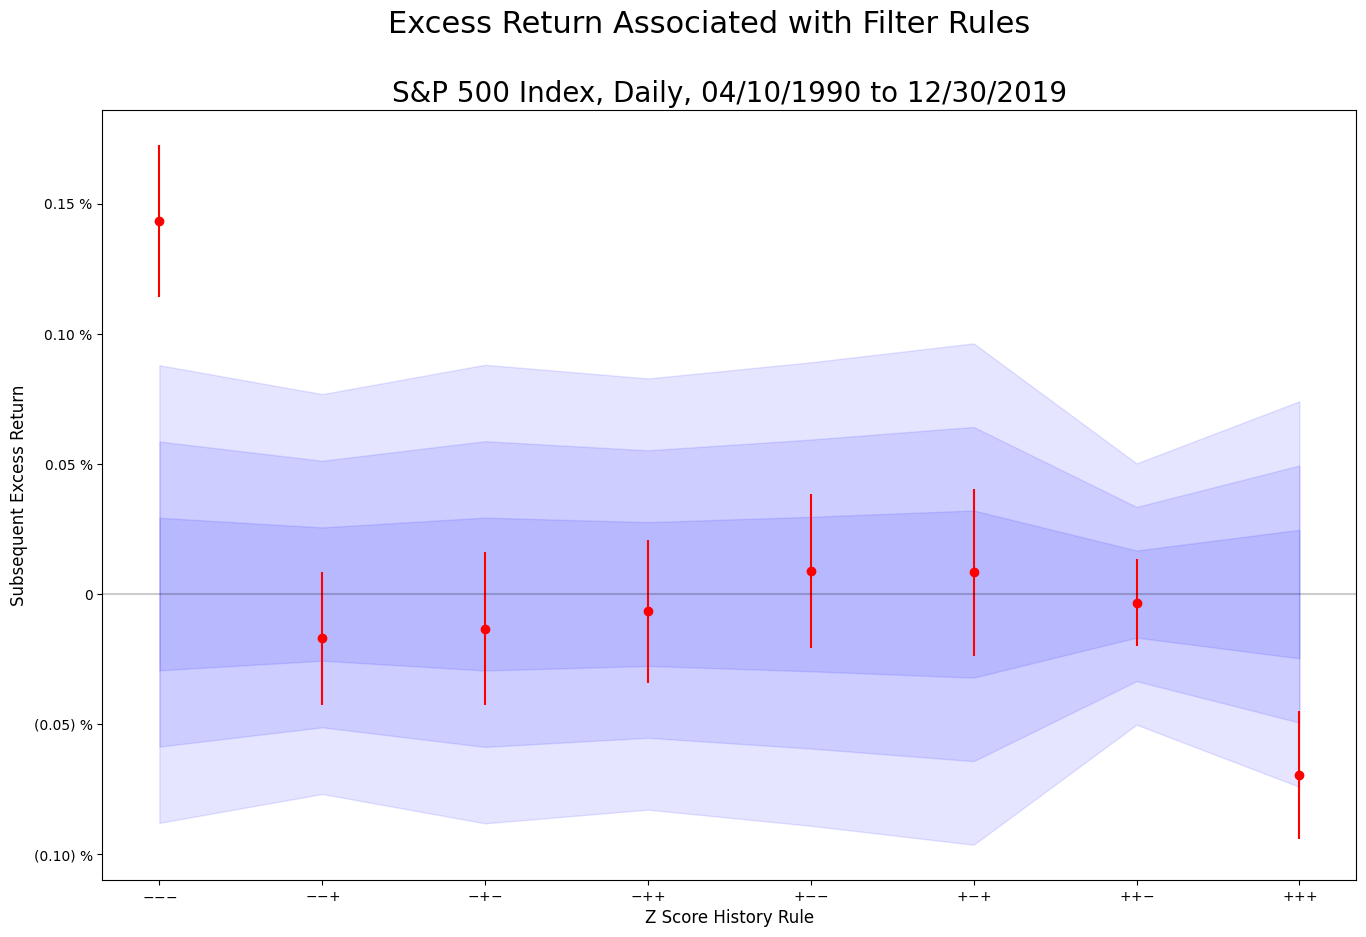

In [94]:
nprint("Creating filter rule indicators with order {:d} and offset {:f}.".format(forder:=3,foffset:=0.1))

data['Direction']=data['Z Score'].apply(lambda x: one if x>foffset else -one if x<-foffset else zero)

for lag in range(1,forder+1):
    data['Z_'+str(lag)]=data['Z Score'].shift(lag)
    data['Direction_'+str(lag)]=data['Direction'].shift(lag)

for rule in range(2**forder):
    rmap=list(map(lambda x:-one if x=='0' else +one,label:="{:0#b}".replace("#",str(forder)).format(rule)))
    data['Filter_'+label]=(data['Direction_1']==rmap[0])

    for lag in range(2,forder+1):
        data['Filter_'+label]&=(data['Direction_'+str(lag)]==rmap[lag-1])

    data['Filter_'+label]=data['Filter_'+label].apply(lambda x:one if x else zero)

nprint("Fitting GJR-GARCH model with filter rules...")
model=ARX((design:=data.dropna())['Return'],design[fcols:=design.columns[design.columns.str.contains('Filter')]])
model.volatility=GARCH2(0,1,1)
model.distribution=GeneralizedError2()
fit=model.fit(update_freq=0,disp='off')
nprint(fit.summary(),sep='\n')
coefficients=pd.DataFrame([fit.params[fcols],fit.std_err[fcols]]).T

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.errorbar(x:=list(map(lambda l:l.replace('Filter_','').replace('0','$-$').replace('1','$+$'),coefficients.index)),y:=coefficients['params'],ye:=coefficients['std_err'],fmt='o',color='red')
plot.axhline(color='black',alpha=0.2)
plot.set_ylabel('Subsequent Excess Return',fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(2))
plot.set_xlabel('Z Score History Rule',fontsize=12)
figure.suptitle(title:='Excess Return Associated with Filter Rules',fontsize=22)
plot.set_title(subtitle:='{:s}, Daily, {:s} to {:s}'.format(sname,data.index[0].strftime("%m/%d/%Y"),data.index[-1].strftime("%m/%d/%Y")),fontsize=20)

for s in range(1,4):
    plot.fill_between(x,-s*ye,y2=s*ye,alpha=0.1,color='blue')

figure.savefig(filename:=(filepath:='/content/drive/MyDrive/')+title+'.png',dpi=300,bbox_inches='tight')
nprint("Saved figure to '{:s}'.".format(filename))

### Fit a Conditional Model to Rules Filter_000 and Filter_111

In [96]:
from posixpath import sep
nprint("Fitting a hybrid conditional autoregression...")
data['Conditional']=(data['Filter_000'].astype(bool)|data['Filter_111'].astype(bool)).astype(float)*data['Return'].shift()
model=ARX((design:=data.dropna())['Return'],design['Conditional'])
model.volatility=GARCH2(0,1,1)
model.distribution=GeneralizedError2()
fit=model.fit(update_freq=0,disp='off')
nprint(fit.summary(),sep='\n')

14:55:17 Fitting a hybrid conditional autoregression...
14:55:17
                              AR-X - GJR-GARCH Model Results                              
Dep. Variable:                             Return   R-squared:                       0.005
Mean Model:                                  AR-X   Adj. R-squared:                  0.005
Vol Model:                              GJR-GARCH   Log-Likelihood:               -9484.11
Distribution:      Generalized Error Distribution   AIC:                           18980.2
Method:                        Maximum Likelihood   BIC:                           19021.7
                                                    No. Observations:                 7486
Date:                            Mon, Feb 03 2025   Df Residuals:                     7484
Time:                                    14:55:17   Df Model:                            2
                                  Mean Model                                 
                  coef    std err     